## Correlation and Convolution to find the time difference of arrival

In [1]:
from scipy.io import wavfile
fs, data = wavfile.read("single-2.wav")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data.shape

(2956, 2)

## Plot the two channels from the audio

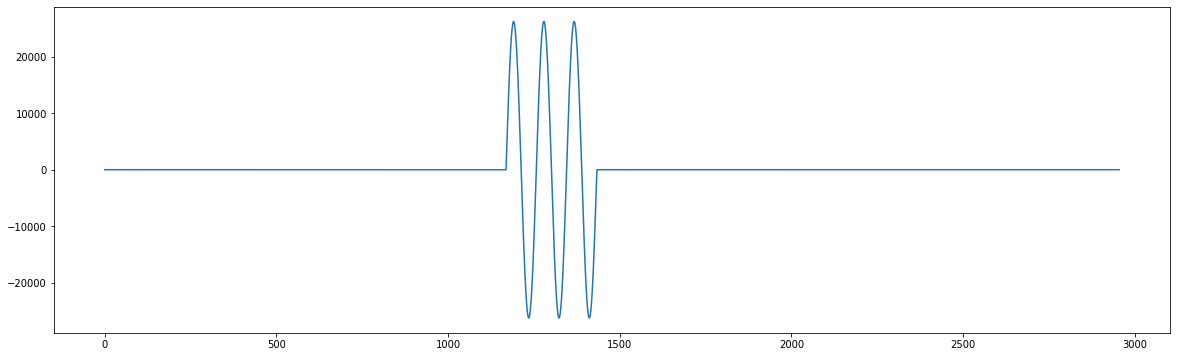

In [3]:
plt.figure(figsize=(20,6))
plt.plot(data[:,0])
plt.show()

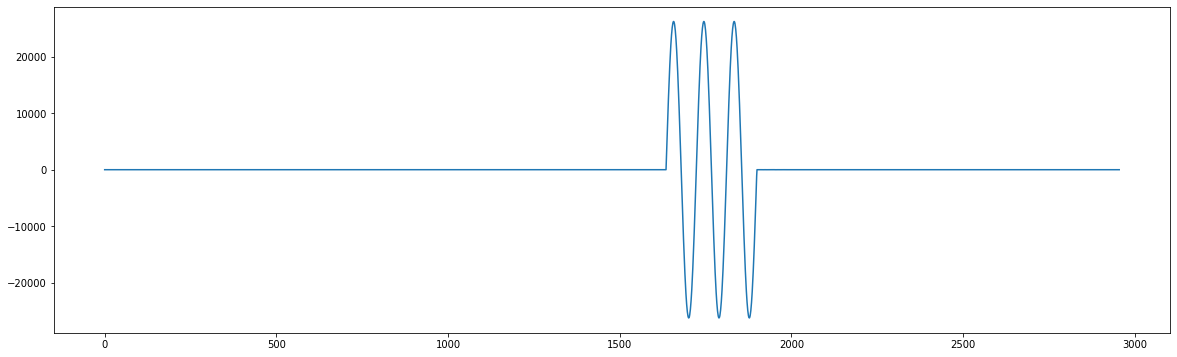

In [4]:
plt.figure(figsize=(20,6))
plt.plot(data[:,1])
plt.show()

In [14]:
fs

44100

In [5]:
from scipy.signal import correlate, convolve

In [6]:
import scipy
af = scipy.fft(data[:,0])
bf = scipy.fft(data[:,1])
c = scipy.ifft(af * scipy.conj(bf))

time_shift = np.argmax(abs(c))
print(time_shift)
print(abs(c).argsort()[-3:][::-1])

2490
[2490 2491 2489]


In [7]:
from scipy import signal
size=data[:,0].shape[0]
max1= np.argmax(signal.correlate(data[:,0],data[:,1]))-(size-1)
max2 = np.argmax(signal.correlate(data[:,1],data[:,0]))-(size-1)
print('tdoa is ', max1/fs, max2/fs)

tdoa is  0.01852607709750567 -0.01852607709750567


### TDoA using signal Correlation

In [137]:
from scipy import signal, fftpack
corr = signal.correlate(data[:,0], data[:,1])
#print(data[:,0].shape)
#print(corr.shape)
#print(corr.argsort()[-3:][::-1])
print(np.argmax(corr))


3772


### Convolution using Fourier transform

466
time difference of arrival is (in secs):  0.01056689342403628


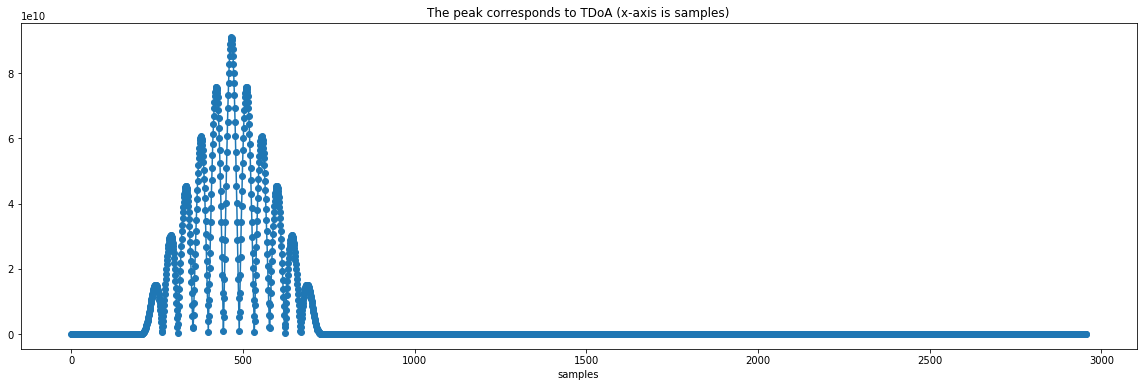

In [139]:

A = fftpack.fft(data[:,0])
B = fftpack.fft(data[:,1])
Ar = -A.conjugate()
Br = -B.conjugate()

tdoa_samples = np.argmax(np.abs(fftpack.ifft(Ar*B)))
print(tdoa_samples)
print('time difference of arrival is (in secs): ',tdoa_samples/fs)
#print(numpy.argmax(numpy.abs(fftpack.ifft(A*Br))))

plt.figure(figsize=(20,6))
plt.plot(np.abs(fftpack.ifft(Ar*B)), 'o-')
plt.title('The peak corresponds to TDoA (x-axis is samples)')
plt.xlabel('samples')
plt.show()

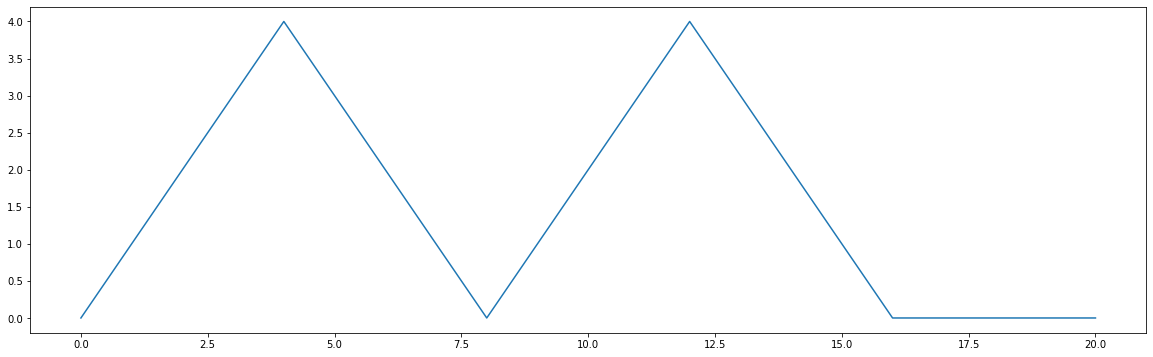

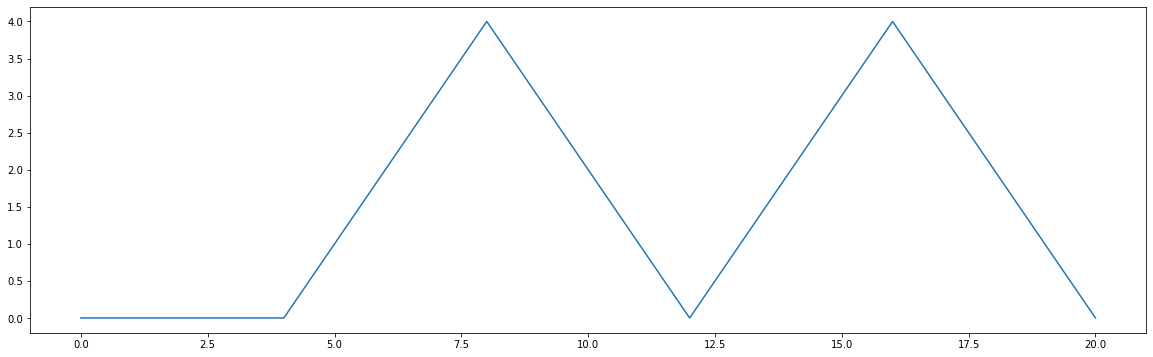

24


In [4]:
# another approach, synthetic data
from scipy import signal, fftpack
import numpy
a = numpy.array([0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 0, 0, 0, 0])
b = numpy.array([0, 0, 0, 0, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0])
plt.figure(figsize=(20,6))
plt.plot(a)
plt.show()
plt.figure(figsize=(20,6))
plt.plot(b)
plt.show()

print(numpy.argmax(signal.correlate(b,a)))



### tasks
1. collecting data from webcam microphone + filtering
2. plug in this data from 1. to check accuracy of source location estimate
3. work on an alternate method to solve the set of 6 tdoa equations
4. test on actual microphone/hydrophone array on pcb board (with filter and adc)

## Implementation of the nonlinear least-squares estimate for finding the coordinates of source/pinger using the 6 tdoa (for 4 microphones/hydrophones)

In [5]:
sourcePos = np.array([[50],[50],[10]]) # in centimeters
print('sourcePos shape=', sourcePos.shape)
l1=7.5
l2=7.5


"""
Microphone array setup
  [m3]<------l1------>[m4]
   |                   |
   l2                  l2
   |                   |
  [m1]<------l1------>[m2]
  
  Origin is located at position of m1 (ie. m1Pos)
"""
m1Pos = np.array([[0],[0],[0]]) # in centimeters
m2Pos = np.array([[l1],[0],[0]]) # in centimeters
m3Pos = np.array([[0],[l2],[0]]) # in centimeters
m4Pos = np.array([[l1],[l2],[0]]) # in centimeters

d1 = np.linalg.norm(sourcePos-m1Pos)
d2 = np.linalg.norm(sourcePos-m2Pos)
d3 = np.linalg.norm(sourcePos-m3Pos)
d4 = np.linalg.norm(sourcePos-m4Pos)
print('sourcePos - m2Pos=\n', sourcePos-m2Pos)
print('d1=',d1)
print('d2=',d2)
print('d3=',d3)
print('d4=',d4)

sourcePos shape= (3, 1)
sourcePos - m2Pos=
 [[42.5]
 [50. ]
 [10. ]]
d1= 71.4142842854285
d2= 66.37959023675877
d3= 66.37959023675877
d4= 60.9302880347697


In [6]:
# 4 choose 2 = 6
# these are 6 pairs of time difference of arrivals
speedOfSound = 340 * 100 # cm/s at 20 degree celsius in air
delTau12 = (d2-d1) / speedOfSound # in seconds
delTau13 = (d3-d1) / speedOfSound
delTau14 = (d4-d1) / speedOfSound
delTau23 = (d3-d2) / speedOfSound
delTau24 = (d4-d2) / speedOfSound
delTau34 = (d4-d3) / speedOfSound

print('delTau12=',delTau12)
print('delTau13=',delTau13)
print('delTau14=',delTau14)
print('delTau23=',delTau23)
print('delTau24=',delTau24)
print('delTau34=',delTau34)

delTau12= -0.00014807923672558002
delTau13= -0.00014807923672558002
delTau14= -0.00030835283090172917
delTau23= 0.0
delTau24= -0.00016027359417614912
delTau34= -0.00016027359417614912


In [6]:
import sympy
from sympy import sqrt, simplify

x, y, z = sympy.symbols("x y z", real=True)

# solve
# 34000*(-0.00014807923672558002)=sqrt((x-7.5)^2+y^2+z^2)-sqrt(x^2+y^2+z^2),
# 34000*(-0.00030835283090172917)=sqrt((x-7.5)^2+(y-7.5)^2+z^2)-sqrt(x^2+y^2+z^2),
# 34000*(-0.00016027359417614912)=sqrt((x-7.5)^2+(y-7.5)^2+z^2)-sqrt((x-7.5)^2+y^2+z^2)
# for x,y,z
eq1 = sympy.Eq(sqrt((x-7.5)**2+(y)**2+(z)**2) - sqrt((x)**2+(y)**2+(z)**2), 34000*(-0.00014807923672558002))
eq2 = sympy.Eq(sqrt((x-7.5)**2+(y-7.5)**2+(z)**2) - sqrt((x)**2+(y)**2+(z)**2), 34000*(-0.00030835283090172917))
eq3 = sympy.Eq(sqrt((x-7.5)**2+(y-7.5)**2+(z)**2) - sqrt((x-7.5)**2+(y)**2+(z)**2), 34000*(-0.00014807923672558002))
sympy.solve([eq1, eq2, eq3])

[]

In [ ]:
# ignore this block of code

def func(x, y, z, a, b, c):
    f = (sqrt(x-)-sqrt())
    f = (a**2
         + x * b**2
         + y * a * b * np.cos(c)
         + z * a * b * np.sin(c))
    return f


def nonlinear_invert(f, x, y, z):
    # "curve_fit" expects the function to take a slightly different form...
    def wrapped_func(observation_points, a, b, c):
        x, y, z = observation_points
        return func(x, y, z, a, b, c)

    xdata = np.vstack([x, y, z])
    model, cov = opt.curve_fit(wrapped_func, xdata, f)
    return model

def generate_data(nobservations, a, b, c, noise_level=0.01):
    x, y, z = np.random.random((3, nobservations))
    noise = noise_level * np.random.normal(0, noise_level, nobservations)
    f = func(x, y, z, a, b, c) + noise
    return f, x, y, z

nobservations = 4
a, b, c = 3.0, 2.0, 1.0
f, x, y, z = generate_data(nobservations, a, b, c)

print 'Non-linear results (should be {}, {}, {}):'.format(a, b, c)
print nonlinear_invert(f, x, y, z)



In [2]:
from scipy.optimize import least_squares
import numpy as np

def fun_tdoa(x, miloc, mjloc, delD):
    sourceloc = x
term1 = (np.linalg.norm(sourceloc-mjloc[0])-np.linalg.norm(sourceloc-miloc[0])) - delD[0]
term2 = (np.linalg.norm(sourceloc-mjloc[1])-np.linalg.norm(sourceloc-miloc[1])) - delD[1]
term3 = (np.linalg.norm(sourceloc-mjloc[2])-np.linalg.norm(sourceloc-miloc[2])) - delD[2]
term4 = (np.linalg.norm(sourceloc-mjloc[3])-np.linalg.norm(sourceloc-miloc[3])) - delD[3]
term5 = (np.linalg.norm(sourceloc-mjloc[4])-np.linalg.norm(sourceloc-miloc[4])) - delD[4]
term6 = (np.linalg.norm(sourceloc-mjloc[5])-np.linalg.norm(sourceloc-miloc[5])) - delD[5]
    return (term1, term2, term3, term4, term5, term6)

l1 = 0.075 # meters
l2 = 0.075 # meters
l3 = 0.010 # meters

"""
Microphone array setup
  [m3]<------l1------>[m4]
   |                   |
   l2                  l2
   |                   |
  [m1]<------l1------>[m2]
  
  Origin is located at position of m1 (ie. m1Pos)
"""
sourcePos = np.array([[1.8],[0.5],[1]]) # in meters
m1Pos = np.array([[0],[0],[0]])
m2Pos = np.array([[l1],[0],[0]])
m3Pos = np.array([[0],[l2],[l3]])
m4Pos = np.array([[l1],[l2],[l3]])

d1 = np.linalg.norm(sourcePos-m1Pos)
d2 = np.linalg.norm(sourcePos-m2Pos)
d3 = np.linalg.norm(sourcePos-m3Pos)
d4 = np.linalg.norm(sourcePos-m4Pos)
# print('d1=',d1)
# print('d2=',d2)
# print('d3=',d3)
# print('d4=',d4)

speedOfSound = 340 # m/s at 20 degree celsius in air
delTau12 = (d2-d1) / speedOfSound # in seconds
delTau13 = (d3-d1) / speedOfSound
delTau14 = (d4-d1) / speedOfSound
delTau23 = (d3-d2) / speedOfSound
delTau24 = (d4-d2) / speedOfSound
delTau34 = (d4-d3) / speedOfSound

print(d2-d1,d3-d1,d4-d1,d3-d2,d4-d2,d4-d3)

def localizeSource(tdoas, l1, l2, l3, speed_of_sound):
    assert l1 < 1, 'you really have 1 meter gap b/w front two microphones?'
    assert l2 < 1, 'you really have 1 meter gap b/w two side microphones?'
    assert speed_of_sound < 2000, 'your speed of sound seems too much.'
    assert len(tdoas) is 6, 'you didnt give exactly tdoas for all 6 microphone pairs'
    
    # distance difference of arrivel = tdoa * speed of sound 
    distdoa = tdoas * speed_of_sound
    
    # initial guess (for nonlinear least squares below)
    x0_tdoa = np.array([-1, -1, .2])
    # mic1, mic1, mic1, mic2, mic2, mic3
    miloc = np.array([[0,0,0],[0,0,0],[0,0,0],[l1,0,0],[l1,0,0],[0,l2,l3]])
    # mic2, mic3, mic4, mic3, mic4, mic4
    mjloc = np.array([[l1,0,0],[0,l2,l3],[l1,l2,l3],[0,l2,l3],[l1,l2,l3],[l1,l2,l3]])
    
    # find estimate of source location using nonlinear least squares
    res_1 = least_squares(fun_tdoa, x0_tdoa, method='trf',
                          args=(miloc, mjloc, distdoa))
    #print(res_1)
    xhat, yhat, zhat = res_1.x
    return xhat, yhat, zhat

# array of (n choose 2) time difference of arrival values
# calculated using correlation of signals recorded at the hydrophones/microphones 
tdoas = np.array([delTau12, delTau13, delTau14, delTau23, delTau24, delTau34])
xhat, yhat, zhat = localizeSource(tdoas, l1, l2, l3, speedOfSound)
print('\nNOTE: all coordinates below are in meters')
print('\nOriginal position of the source (x, y, z) is')
print('({}, {}, {})'.format(sourcePos[0], sourcePos[1], sourcePos[2]))
print('\nEstimated position of the source (xhat, yhat, zhat) is')
print('({}, {}, {})'.format(xhat, yhat, zhat))
estimate = np.array([[xhat],[yhat],[zhat]])
print('error in estimate is', np.linalg.norm(estimate-sourcePos)**2)
print('\n\n')


def calculateAngles(xhat, yhat, zhat):
    alpha = np.arctan2(yhat, xhat)*180/np.pi
    xy_projection = np.linalg.norm(np.array([xhat,yhat]))
    beta = np.arctan2(zhat, xy_projection)*180/np.pi
    return alpha, beta

alpha, beta = calculateAngles(xhat, yhat, zhat)
print('alpha={} degrees'.format(alpha))
print('beta={} degrees'.format(beta))

-0.06332950397453718 -0.021171505725322337 -0.08516015145272648 0.042157998249214845 -0.021830647478189302 -0.06398864572740415

NOTE: all coordinates below are in meters

Original position of the source (x, y, z) is
([1.8], [0.5], [1.])

Estimated position of the source (xhat, yhat, zhat) is
(1.7999965124148336, 0.49999878209962667, 1.0000004016086292)
error in estimate is 1.3807821103605764e-11



alpha=15.524103634838042 degrees
beta=28.159653317458012 degrees


In [81]:
error = (8*np.pi)/180# radians
distance=10 # meters
seperation = 0.60*np.sqrt(2) # meters
print(seperation)

sourcePos1 = np.array([[distance],[0],[1]])
sourcePos2 = np.array([[distance*np.cos(error)],[distance*np.sin(error)],[1]])
mic1 = np.array([[-seperation/2],[0],[0]])
mic2 = np.array([[seperation/2],[0],[0]])

ddoa_true = np.linalg.norm(sourcePos1-mic1) - np.linalg.norm(sourcePos1-mic2)
ddoa_got = np.linalg.norm(sourcePos2-mic1) - np.linalg.norm(sourcePos2-mic2)

print(ddoa_true, ddoa_got)

print((ddoa_true-ddoa_got)*100) # centimeters


print(1500/(ddoa_true-ddoa_got)) # required ADC sampling rate in Hz

0.848528137423857
0.8443095914820002 0.8360785169025018
0.8231074579498454
182236.229973681


In [27]:
def localizeSource(tdoas, speed_of_sound):
    assert l1 < 1, 'you really have 1 meter gap b/w front two microphones?'
    assert l2 < 1, 'you really have 1 meter gap b/w two side microphones?'
    assert speed_of_sound < 2000, 'your speed of sound seems too much.'
    assert len(tdoas) is 6, 'you didnt give exactly tdoas for all 6 microphone pairs'
    
    # distance difference of arrivel = tdoa * speed of sound 
    distdoa = tdoas * speed_of_sound # meters
    
    # initial guess (for nonlinear least squares below)
    x0_tdoa = np.array([1, 1, .2])
    
    # - mic locations
    m1 = np.array([[-3.7/100],[0],[0]]) # meters
    m2 = np.array([[3.7/100],[0],[0]]) # meters
    m3 =  np.array([[-3.7/100],[-6.8/100],[0]]) # meters
    m4 = np.array([[3.7/100],[-6.8/100],[0]]) # meters

    # mic1, mic1, mic1, mic2, mic2, mic3
    miloc = np.array([[-3.7/100,0,0],[-3.7/100,0,0],[-3.7/100,0,0],
                      [3.7/100,0,0],[3.7/100,0,0],[-3.7/100,-6.8/100,0]])
    # mic2, mic3, mic4, mic3, mic4, mic4
    mjloc = np.array([[3.7/100,0,0],[-3.7/100,-6.8/100,0],[3.7/100,-6.8/100,0],
                      [-3.7/100,-6.8/100,0],[3.7/100,-6.8/100,0],[3.7/100,-6.8/100,0]])
    
    # find estimate of source location using nonlinear least squares
    res_1 = least_squares(fun_tdoa, x0_tdoa, method='trf', loss='huber',
                          bounds=([-1, -5, -2], [10, 8, 4]), args=(miloc, mjloc, distdoa))
    print(res_1)
    xhat, yhat, zhat = res_1.x
    return xhat, yhat, zhat

fs=44100
delTau12 = 5/fs
delTau13 = 7/fs
delTau14 = 12/fs
delTau23 = 2/fs
delTau24 = 7/fs
delTau34 = 5/fs

# x=84.5cm
#y=104.2+0.7cm
#z=49cm-2.8

labSpeakerPos = np.array([[-84.5/100],[104.9/100],[46.2/100]]) # in meters

# - estimate location
tdoas = np.array([delTau12, delTau13, delTau14, delTau23, delTau24, delTau34])
xhat, yhat, zhat = localizeSource(tdoas, 343)

print('\nOriginal position of the source (x, y, z) is')
print('({}, {}, {})'.format(labSpeakerPos[0], labSpeakerPos[1], labSpeakerPos[2]))

alpha, beta = calculateAngles(labSpeakerPos[0], labSpeakerPos[1], labSpeakerPos[2])
print('original alpha={} degrees'.format(alpha))
print('original beta={} degrees'.format(beta))

print('\nEstimated position of the source (xhat, yhat, zhat) is')
print('({}, {}, {})'.format(xhat, yhat, zhat))

alpha, beta = calculateAngles(xhat, yhat, zhat)
print('alpha={} degrees'.format(alpha))
print('beta={} degrees'.format(beta))

estimate = np.array([[xhat],[yhat],[zhat]])
print('error in estimate is', np.linalg.norm(estimate-sourcePos)**2)
print('\n\n')


 active_mask: array([0, 0, 0])
        cost: 6.182184537728568e-07
         fun: array([ 5.39826558e-04,  5.50046492e-04, -2.15664617e-05,  1.02199345e-05,
       -5.61393020e-04, -5.71612954e-04])
        grad: array([1.23547993e-06, 3.50392673e-10, 2.81065400e-10])
         jac: array([[-0.02823824, -0.0166822 , -0.00614075],
       [ 0.01491444,  0.01248482, -0.00849527],
       [-0.01313217, -0.00352453, -0.01413117],
       [ 0.04315268,  0.02916702, -0.00235452],
       [ 0.01510607,  0.01315768, -0.00799042],
       [-0.02804661, -0.01600934, -0.0056359 ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 13
        njev: 13
  optimality: 2.2740972222245197e-09
      status: 1
     success: True
           x: array([-0.99999543,  1.4901392 ,  0.54852329])

Original position of the source (x, y, z) is
([-0.845], [1.049], [0.462])
original alpha=[128.85245421] degrees
original beta=[18.93108665] degrees

Estimated position of the source (xhat, yhat, zhat) i

Actual DoAs: [1.23420657] 

MUSIC DoAs: [-0.04813025  1.25576197] 

ESPRIT DoAs: [-0.09758516] 



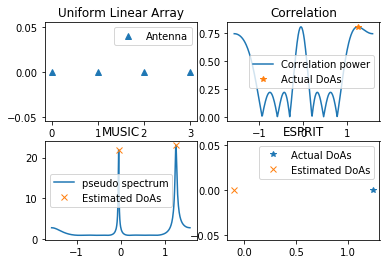

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import scipy.signal as ss
import operator

%matplotlib inline

# Functions
def array_response_vector(array, theta):
    N = array.shape
    v = np.exp(1j*2*np.pi*array*np.sin(theta))
    return v/np.sqrt(N)

def music(CovMat,L,N,array,Angles):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements
    # Angles are the grid of directions in the azimuth angular domain
    _,V = LA.eig(CovMat)
    Qn  = V[:,L:N]
    numAngles = Angles.size
    pspectrum = np.zeros(numAngles)
    for i in range(numAngles):
        av = array_response_vector(array,Angles[i])
        pspectrum[i] = 1/LA.norm((Qn.conj().transpose()@av))
    psindB    = np.log10(10*pspectrum/pspectrum.min())
    DoAsMUSIC,_= ss.find_peaks(psindB,height=1.35, distance=1.5)
    return DoAsMUSIC,pspectrum

def esprit(CovMat,L,N):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    _,U = LA.eig(CovMat)
    S = U[:,0:L]
    Phi = LA.pinv(S[0:N-1]) @ S[1:N] # the original array is divided into two subarrays [0,1,...,N-2] and [1,2,...,N-1]
    eigs,_ = LA.eig(Phi)
    DoAsESPRIT = np.arcsin(np.angle(eigs)/np.pi)
    return DoAsESPRIT
#=============================================================

np.random.seed(6)

lamda = 343/9000 # wavelength, in meters
kappa = np.pi/lamda # wave number
L = 1  # number of sources
N = 4  # number of ULA elements 
snr = 10 # signal to noise ratio


array = np.linspace(0,(N-1),N)

plt.figure()
plt.subplot(221)
plt.plot(array,np.zeros(N),'^')
plt.title('Uniform Linear Array')
plt.legend(['Antenna'])


Thetas = np.pi*(np.random.rand(L)-1/2)   # random source directions
Alphas = np.random.randn(L) + np.random.randn(L)*1j # random source powers
Alphas = np.sqrt(1/2)*Alphas
#print(Thetas)
#print(Alphas)

h = np.zeros(N)
for i in range(L):
    h = h + Alphas[i]*array_response_vector(array,Thetas[i])

Angles = np.linspace(-np.pi/2,np.pi/2,360)
numAngles = Angles.size

hv = np.zeros(numAngles)
for j in range(numAngles):
    av = array_response_vector(array,Angles[j])
    hv[j] = np.abs(np.inner(h,av.conj()))

powers = np.zeros(L)
for j in range(L):
    av = array_response_vector(array,Thetas[j])
    powers[j] = np.abs(np.inner(h,av.conj()))

plt.subplot(222)
plt.plot(Angles,hv)
plt.plot(Thetas,powers,'*')
plt.title('Correlation')
plt.legend(['Correlation power','Actual DoAs'])
numrealization = 100
H = np.zeros((N,numrealization)) + 1j*np.zeros((N,numrealization))

for iter in range(numrealization):
    htmp = np.zeros(N)
    for i in range(L):
        pha = np.exp(1j*2*np.pi*np.random.rand(1))
        htmp = htmp + pha*Alphas[i]*array_response_vector(array,Thetas[i])
    H[:,iter] = htmp + np.sqrt(0.5/snr)*(np.random.randn(N)+np.random.randn(N)*1j)
CovMat = H@H.conj().transpose()

# MUSIC algorithm
DoAsMUSIC, psindB = music(CovMat,L,N,array,Angles)


plt.subplot(223)
plt.plot(Angles,psindB)
plt.plot(Angles[DoAsMUSIC],psindB[DoAsMUSIC],'x')
plt.title('MUSIC')
plt.legend(['pseudo spectrum','Estimated DoAs'])

# ESPRIT algorithm
DoAsESPRIT = esprit(CovMat,L,N)
plt.subplot(224)
plt.plot(Thetas,np.zeros(L),'*')
plt.plot(DoAsESPRIT,np.zeros(L),'x')
plt.title('ESPRIT')
plt.legend(['Actual DoAs','Estimated DoAs'])

print('Actual DoAs:',np.sort(Thetas),'\n')
print('MUSIC DoAs:',np.sort(Angles[DoAsMUSIC]),'\n')
print('ESPRIT DoAs:',np.sort(DoAsESPRIT),'\n')

plt.show()

[5.10529135 4.67353988]
MUSIC
MUSIC
  Recovered azimuth: [296.] degrees
  Error: [60.] degrees
SRP
SRP
  Recovered azimuth: [220.] degrees
  Error: [16.] degrees
CSSM
CSSM
  Recovered azimuth: [9.] degrees
  Error: [133.] degrees
WAVES
WAVES
  Recovered azimuth: [135.] degrees
  Error: [101.] degrees
TOPS
TOPS
  Recovered azimuth: [101.] degrees
  Error: [135.] degrees


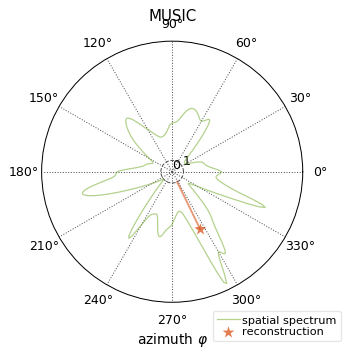

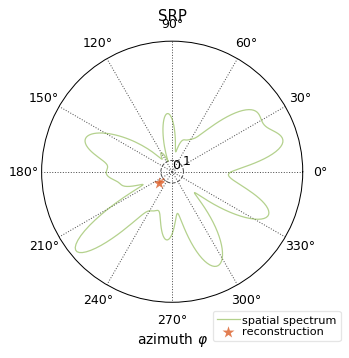

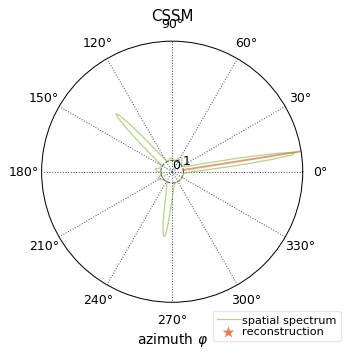

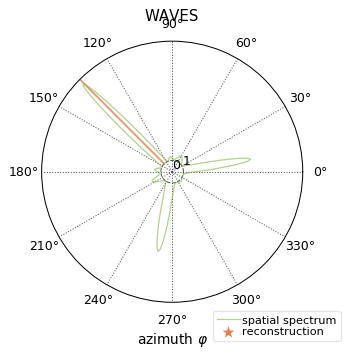

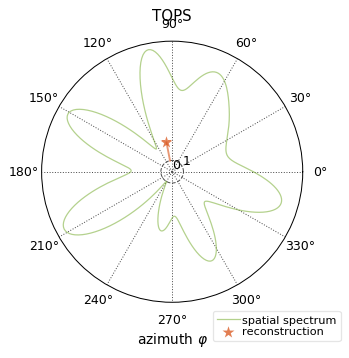

In [128]:
'''
DOA Algorithms
==============

This example demonstrates how to use the DOA object to perform direction of arrival
finding in 2D using one of several algorithms

- MUSIC [1]_
- SRP-PHAT [2]_
- CSSM [3]_
- WAVES [4]_
- TOPS [5]_
- FRIDA [6]_

.. [1] R. Schmidt, *Multiple emitter location and signal parameter estimation*, 
    IEEE Trans. Antennas Propag., Vol. 34, Num. 3, pp 276--280, 1986

.. [2] J. H. DiBiase, J H, *A high-accuracy, low-latency technique for talker localization 
    in reverberant environments using microphone arrays*, PHD Thesis, Brown University, 2000

.. [3] H. Wang, M. Kaveh, *Coherent signal-subspace processing for the detection and 
    estimation of angles of arrival of multiple wide-band sources*, IEEE Trans. Acoust., 
    Speech, Signal Process., Vol. 33, Num. 4, pp 823--831, 1985

.. [4] E. D. di Claudio, R. Parisi, *WAVES: Weighted average of signal subspaces for 
    robust wideband direction finding*, IEEE Trans. Signal Process., Vol. 49, Num. 10, 
    2179--2191, 2001

.. [5] Y. Yeo-Sun, L. M. Kaplan, J. H. McClellan, *TOPS: New DOA estimator for wideband 
    signals*, IEEE Trans. Signal Process., Vol. 54, Num 6., pp 1977--1989, 2006

.. [6] H. Pan, R. Scheibler, E. Bezzam, I. Dokmanić, and M. Vetterli, *FRIDA:
    FRI-based DOA estimation for arbitrary array layouts*, Proc. ICASSP,
    pp 3186-3190, 2017

In this example, we generate some random signal for a source in the far field
and then simulate propagation using a fractional delay filter bank
corresponding to the relative microphone delays.

Then we perform DOA estimation and compare the errors for different algorithms

'''

import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

######
# We define a meaningful distance measure on the circle

# Location of original source
azimuth = -124 / 180. * np.pi  # -124 degrees
distance = 1.6  # 1.6 meters

#######################
# algorithms parameters
SNR = 0.    # signal-to-noise ratio
c = 343.    # speed of sound
fs = 44100  # sampling frequency
nfft = 256  # FFT size
#freq_bins = np.arange(5, 60)  # FFT bins to use for estimation
freq_bins = np.arange(5, 60)  # FFT bins to use for estimation


# compute the noise variance
sigma2 = 10**(-SNR / 10) / (4. * np.pi * distance)**2

# Create an anechoic room
room_dim = np.r_[12.,12.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# add the source
source_location = room_dim / 2 + distance * np.r_[np.cos(azimuth), np.sin(azimuth)]

print(source_location)
source_signal = np.random.randn((nfft // 2 + 1) * nfft)

fs=44100 # hz
t=0.006 # seconds
f=9000 # hz
samples = np.arange(t * fs) / fs

sig = np.sin(2 * np.pi * f * samples)

sig = np.float32(sig)



# print(sig)
aroom.add_source(source_location, signal=sig)

# We use a circular array with radius 15 cm # and 12 microphones
R = pra.circular_2D_array(room_dim/2+np.r_[0.84, 1.4], 4, 0., 0.05/np.sqrt(2))
aroom.add_microphone_array(pra.MicrophoneArray(R, fs=aroom.fs))

# run the simulation
aroom.simulate()

################################
# Compute the STFT frames needed
X = np.array([ 
    pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T 
    for signal in aroom.mic_array.signals ])

##############################################
# Now we can test all the algorithms available
algo_names = sorted(pra.doa.algorithms.keys())
# algo_names = ['MUSIC', 'SRP', 'CSSM', 'WAVES', 'TOPS', 'FRIDA']
algo_names = ['MUSIC', 'SRP', 'CSSM', 'WAVES', 'TOPS']
for algo_name in algo_names:
    print(algo_name)
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)

    doa.polar_plt_dirac()
    plt.title(algo_name)
    
    # doa.azimuth_recon contains the reconstructed location of the source
    print(algo_name)
    print('  Recovered azimuth:', doa.azimuth_recon / np.pi * 180., 'degrees')
    print('  Error:', circ_dist(azimuth, doa.azimuth_recon) / np.pi * 180., 'degrees')

plt.show()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


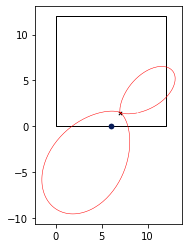

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra

# Create a 4 by 6 metres shoe box room
room = pra.ShoeBox([12, 12],fs=44100)

# Add a source somewhere in the room
room.add_source([6, 0])

# Create a linear array beamformer with 4 microphones
# with angle 0 degrees and inter mic distance 10 cm
# R = pra.linear_2D_array([2, 1.5], 4, 0, 0.1)
R = pra.circular_2D_array([7, 1.5], 4, 0., 0.015/np.sqrt(2))
room.add_microphone_array(pra.Beamformer(R, room.fs))

# Now compute the delay and sum weights for the beamformer
room.mic_array.rake_delay_and_sum_weights(room.sources[0][:1])

# plot the room and resulting beamformer
room.plot(freq=[9000], img_order=0)
plt.show()

In [8]:
grid = np.zeros((101,101))
print(grid.shape)

(101, 101)


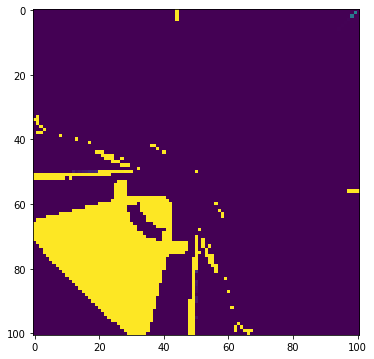

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

l1 = 0.075 # meters
l2 = 0.075 # meters

def VisualizeGrid(grid):
    plt.figure(figsize=(14, 6))
    plt.imshow(grid)
    plt.show()

for row in range(0,101):
    for col in range(0, 101):
        x = col - 50
        y = 50 - row
        
        # x=1 => 0.1m, x=10 => 1m
        sourcePos = np.array([[x/10],[y/10],[1.]]) # in meters
        m1Pos = np.array([[0],[0],[0]])
        m2Pos = np.array([[l1],[0],[0]])
        m3Pos = np.array([[0],[l2],[0]])
        m4Pos = np.array([[l1],[l2],[0]])

        d1 = np.linalg.norm(sourcePos-m1Pos)
        d2 = np.linalg.norm(sourcePos-m2Pos)
        d3 = np.linalg.norm(sourcePos-m3Pos)
        d4 = np.linalg.norm(sourcePos-m4Pos)

        speedOfSound = 340 # m/s at 20 degree celsius in air
        delTau12 = (d2-d1) / speedOfSound # in seconds
        delTau13 = (d3-d1) / speedOfSound
        delTau14 = (d4-d1) / speedOfSound
        delTau23 = (d3-d2) / speedOfSound
        delTau24 = (d4-d2) / speedOfSound
        delTau34 = (d4-d3) / speedOfSound
        
        tdoas = np.array([delTau12, delTau13, delTau14, delTau23, delTau24, delTau34])
        xhat, yhat, zhat = localizeSource(tdoas, l1, l2, speedOfSound)
        estimate = np.array([[xhat],[yhat],[zhat]])
        error = np.linalg.norm(estimate-sourcePos)**2
        grid[row][col] = error

VisualizeGrid(grid)

(101, 101)
row= 0
row= 10
row= 20
row= 30
row= 40
row= 50
row= 60
row= 70
row= 80
row= 90
row= 100


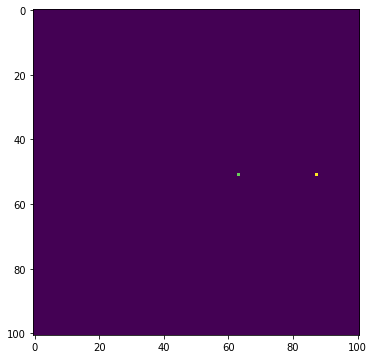

In [103]:
grid2 = np.zeros((101,101))
print(grid2.shape)

def VisualizeGrid(grid):
    plt.figure(figsize=(14, 6))
    plt.imshow(grid)
    plt.show()

for row in range(0,101):
    if row % 10 is 0:
        print('row=', row)
    for col in range(0, 101):
        # tmp: 53,48
        # x = -2, y = -3
        # tmp: 59,64
        # x = 14, y = -9
        # tmp: 45, 68
        # x=18, y=5
        x = col - 50
        y = 50 - row
        
        # x=1 => 0.1m, x=10 => 1m
        sourcePos = np.array([[x/10],[y/10],[1.]]) # in meters

        d1 = np.linalg.norm(sourcePos-m1Pos)
        d2 = np.linalg.norm(sourcePos-m2Pos)
        d3 = np.linalg.norm(sourcePos-m3Pos)
        d4 = np.linalg.norm(sourcePos-m4Pos)

        speedOfSound = 340 # m/s at 20 degree celsius in air
        delTau12 = (d2-d1) / speedOfSound # in seconds
        delTau13 = (d3-d1) / speedOfSound
        delTau14 = (d4-d1) / speedOfSound
        delTau23 = (d3-d2) / speedOfSound
        delTau24 = (d4-d2) / speedOfSound
        delTau34 = (d4-d3) / speedOfSound
        
        tdoas = np.array([delTau12, delTau13, delTau14, delTau23, delTau24, delTau34])
        xhat, yhat, zhat = localizeSource(tdoas, l1, l2, l3, speedOfSound)
        estimate = np.array([[xhat],[yhat],[zhat]])
        error = np.linalg.norm(estimate-sourcePos)**2
        grid2[row][col] = error

VisualizeGrid(grid2)

In [104]:
print(np.max(grid2))

5870.082064685007


In [54]:
subgrid = grid2[53,48]
print(np.max(subgrid))
print(subgrid)

53.613969465339636
53.613969465339636


In [58]:
subgrid2 = grid2[1:52,:]
print(np.max(subgrid2))
subgrid3 = grid2[54:,:]
print(np.max(subgrid3))
subgrid4 = grid2[53,1:48]
print(np.max(subgrid4))
subgrid5 = grid2[53,49:]
print(np.max(subgrid5))

3.8439990992406763
6.083999674019885
9.08664266138577e-06
0.038462194759831786


In [62]:
subgrid6 = grid2[59:,:]
print(np.max(subgrid6))
print(np.argmax(subgrid6))

6.083999674019885
64


In [65]:
print(grid2[59,64])

6.083999674019885


In [73]:
np.sum(grid2 > 2)

93

In [105]:
ind = np.unravel_index(np.argsort(grid2, axis=None), grid2.shape)
rowlist, collist = ind
rowlist50 = rowlist[-50:]
collist50 = collist[-50:]
print(*zip(rowlist[-50:], collist[-50:]))
for idx, row in enumerate(rowlist50):
    col = collist50[idx]
    print(grid2[row,col])

(50, 81) (50, 79) (50, 82) (50, 76) (50, 95) (50, 96) (50, 88) (50, 83) (50, 84) (50, 85) (50, 93) (50, 89) (50, 80) (50, 94) (50, 92) (50, 90) (50, 97) (50, 91) (50, 98) (50, 99) (50, 100) (52, 72) (52, 71) (53, 74) (53, 75) (53, 76) (54, 59) (54, 77) (54, 78) (54, 76) (55, 60) (55, 79) (55, 80) (55, 77) (55, 78) (56, 80) (56, 61) (57, 63) (58, 80) (59, 90) (59, 84) (60, 92) (60, 89) (51, 64) (62, 100) (62, 95) (63, 95) (64, 95) (51, 63) (51, 87)
3.9300537180774766
3.9300774020599687
3.930087925378236
3.9300935089373117
3.9300962715540657
3.930104283669495
3.930109534328734
3.93012032828277
3.9301214414101584
3.9301283136155645
3.9301288562434826
3.930129427682139
3.930131287225139
3.9301316362450023
3.9301331590232444
3.930149771987377
3.930227093226172
3.930281024884537
3.93046745366117
3.9307302287465924
3.9312363473999214
4.142531937756369
4.142532538341046
4.250734800739896
4.250829516096974
4.250829675092171
4.360392044098076
4.360523982767935
4.360524011680079
4.36058028016004


## Load actual webcam recordings (4 audio channels, 2 from each webcam)

In [1]:
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/abhi/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(96256, 2)


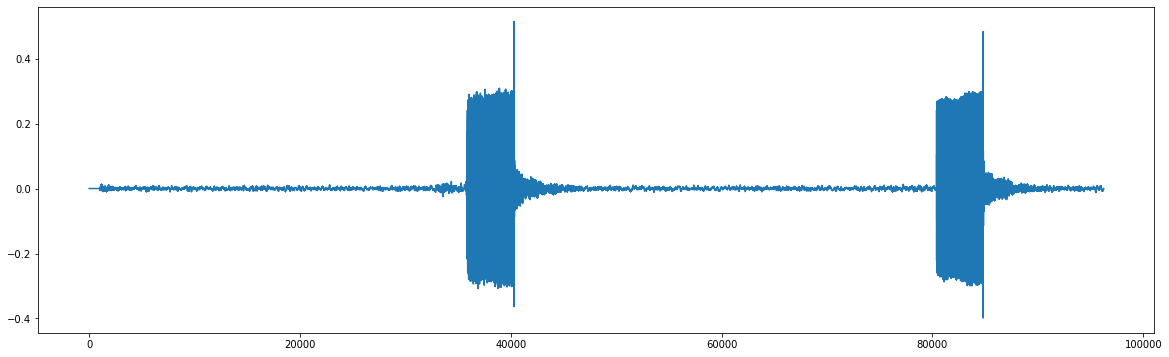

In [100]:
fs, data1 = wavfile.read("lapbeep1.wav")
print(data1.shape)
plt.figure(figsize=(20,6))
plt.plot(data1[:,0])
plt.show()

(96256, 2)


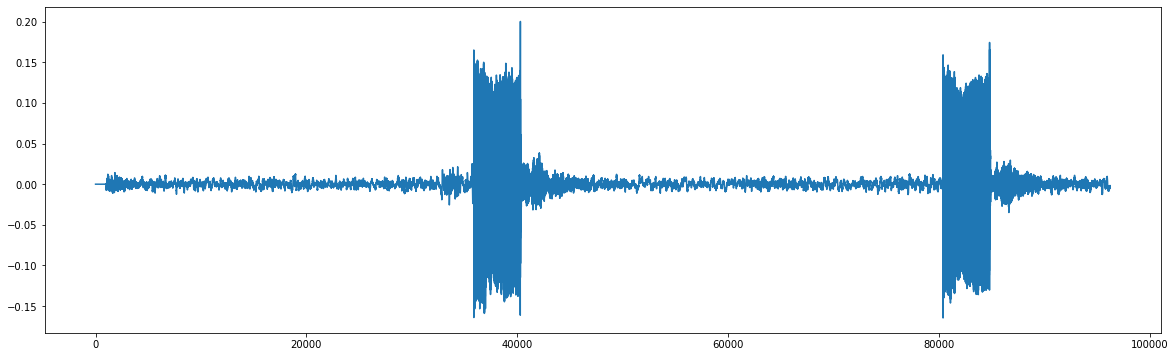

In [101]:
fs, data2 = wavfile.read("lapbeep2.wav")
print(data2.shape)
plt.figure(figsize=(20,6))
plt.plot(data2[:,0])
plt.show()

(95232, 2)


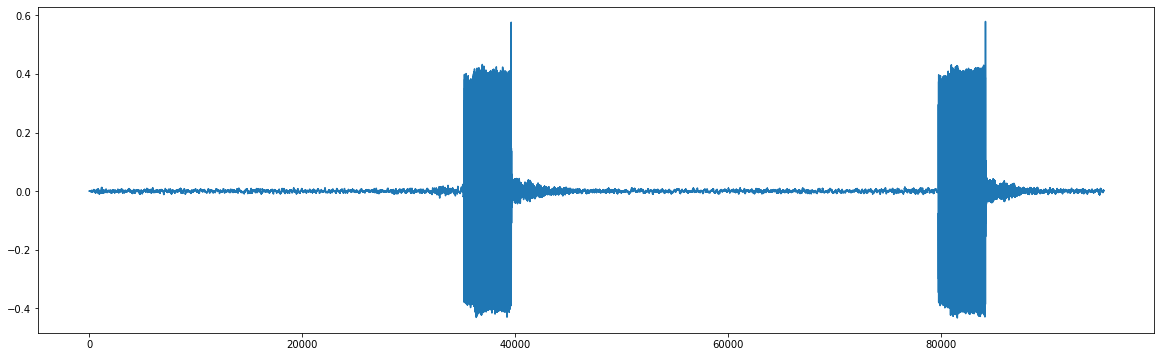

In [102]:
fs, data3 = wavfile.read("lapbeep3.wav")
print(data3.shape)
plt.figure(figsize=(20,6))
plt.plot(data3[:,0])
plt.show()

44100
(95232, 2)


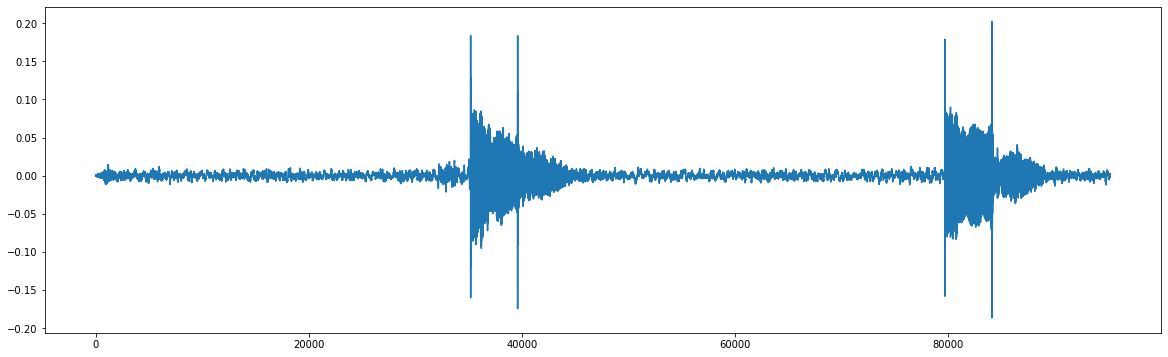

In [103]:
fs, data4 = wavfile.read("lapbeep4.wav")
print(fs)
print(data4.shape)
plt.figure(figsize=(20,6))
plt.plot(data4[:,0])
plt.show()


In [104]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

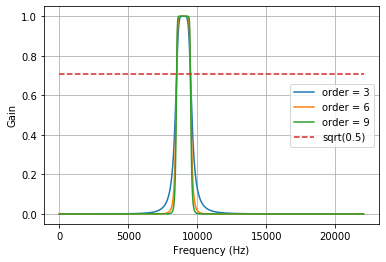

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 44100.0
lowcut = 8500.0
highcut = 9500.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

2.159455782312925
95232.0


/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


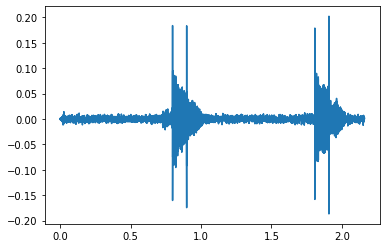

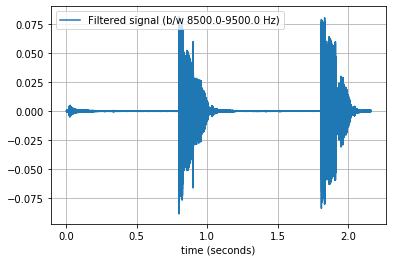

In [109]:
samples = data4[:,0]
fs=44100
T = samples.shape[0]/fs
print(T)
nsamples = T * fs
print(nsamples)
t = np.linspace(0, T, nsamples, endpoint=False)
plt.figure(2)
plt.clf()
plt.plot(t, samples, label='Noisy signal')
plt.show()

lowcut = 8500.0
highcut = 9500.0

y = butter_bandpass_filter(samples, lowcut, highcut, 44100, order=6)
plt.plot(t, y, label='Filtered signal (b/w {}-{} Hz)'.format(lowcut, highcut))
plt.xlabel('time (seconds)')
#plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

No handles with labels found to put in legend.


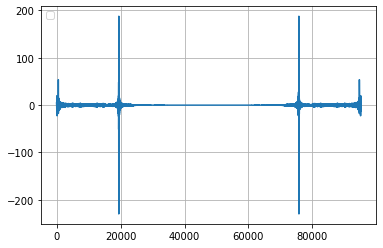

In [110]:
samples = data4[:,0]
A = fftpack.fft(samples)
plt.plot(-A.conjugate())
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [121]:
from scipy import signal, fftpack
fs=44100
start=int(0.5*fs)
numSamples=int(1.5*fs)

lowcut = 8500.0 # Hz
highcut = 9500.0

def findTDoA(samplesA, samplesB, fs, lowcut, highcut, order=6):
    #A = fftpack.fft(samplesA)
    A = fftpack.fft(butter_bandpass_filter(samplesA, lowcut, highcut, fs, order=order))

    #B = fftpack.fft(samplesB)
    B = fftpack.fft(butter_bandpass_filter(samplesB, lowcut, highcut, fs, order=order))

    Ar = -A.conjugate()
    Br = -B.conjugate()

    tdoa_samples = np.argmax(np.abs(fftpack.ifft(Ar*B)))
    print('shifting B by {} samples gives max overlap b/w signals'.format(tdoa_samples))
    print('time difference of arrival is (in secs): ',tdoa_samples/fs)

    """
    plt.figure(figsize=(20,6))
    plt.plot(np.abs(fftpack.ifft(Ar*B)), 'o-')
    plt.title('The peak corresponds to TDoA (x-axis is samples)')
    plt.xlabel('samples')
    plt.show()
    """

    return tdoa_samples/fs

samplesA = data4[:,0][start:numSamples]
samplesB = data2[:,0][start:numSamples]

print('tdoa is ', findTDoA(samplesA, samplesB, fs, lowcut, highcut, order=6))


shifting B by 691 samples gives max overlap b/w signals
time difference of arrival is (in secs):  0.015668934240362812
tdoa is  0.015668934240362812


In [122]:
samplesA = data2[:,0][start:numSamples]
samplesB = data1[:,0][start:numSamples]

print('tdoa12 is ', findTDoA(samplesA, samplesB, fs, lowcut, highcut, order=6))

samplesA = data3[:,0][start:numSamples]
samplesB = data1[:,0][start:numSamples]

print('tdoa13 is ', findTDoA(samplesA, samplesB, fs, lowcut, highcut, order=6))

samplesA = data4[:,0][start:numSamples]
samplesB = data1[:,0][start:numSamples]

print('tdoa14 is ', findTDoA(samplesA, samplesB, fs, lowcut, highcut, order=6))

samplesA = data3[:,0][start:numSamples]
samplesB = data2[:,0][start:numSamples]

print('tdoa23 is ', findTDoA(samplesA, samplesB, fs, lowcut, highcut, order=6))

samplesA = data4[:,0][start:numSamples]
samplesB = data2[:,0][start:numSamples]

print('tdoa24 is ', findTDoA(samplesA, samplesB, fs, lowcut, highcut, order=6))

samplesA = data4[:,0][start:numSamples]
samplesB = data3[:,0][start:numSamples]

print('tdoa34 is ', findTDoA(samplesA, samplesB, fs, lowcut, highcut, order=6))


shifting B by 44097 samples gives max overlap b/w signals
time difference of arrival is (in secs):  0.9999319727891156
tdoa12 is  0.9999319727891156
shifting B by 673 samples gives max overlap b/w signals
time difference of arrival is (in secs):  0.01526077097505669
tdoa13 is  0.01526077097505669
shifting B by 688 samples gives max overlap b/w signals
time difference of arrival is (in secs):  0.015600907029478459
tdoa14 is  0.015600907029478459
shifting B by 698 samples gives max overlap b/w signals
time difference of arrival is (in secs):  0.015827664399092972
tdoa23 is  0.015827664399092972
shifting B by 691 samples gives max overlap b/w signals
time difference of arrival is (in secs):  0.015668934240362812
tdoa24 is  0.015668934240362812
shifting B by 15 samples gives max overlap b/w signals
time difference of arrival is (in secs):  0.0003401360544217687
tdoa34 is  0.0003401360544217687
